In [1]:
# imports
import os
import sys
import glob
import re
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

In [2]:
#################
### Constants ###
#################
RANDOM_WALK_N = 20
subject_names = ['yaleB01', 'yaleB02', 'yaleB05', 'yaleB07']
save_flag = True

In [3]:
#####################################
### Provided functions start here ###
#####################################

# Image loading and saving

def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)


# Plot the height map

def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(20, 80)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)


# Plot the surface normals

def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])


#######################################
### Your implementation starts here ###
#######################################

def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    imarray_t = np.transpose(imarray, (2, 0, 1))
    sub_imarray_t = imarray_t - ambimage
    sub_imarray = np.transpose(sub_imarray_t, (1, 2, 0))
    non_neg_imarray = np.where(sub_imarray < 0, 0, sub_imarray)
    processed_imarray = non_neg_imarray / 255
    
    if imarray.shape != processed_imarray.shape:
        print("Mismatching shapes")
        return None
    
    return processed_imarray


def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    # get surface normals and albedo
    h, w, Nimages = imarray.shape
    surface_normals = np.empty((h, w, 3))
    albedo_image = np.empty((h, w))
    for row in range(h):
        for col in range(w):
            g, res, rank, s = np.linalg.lstsq(light_dirs, imarray[row][col])
            g_array = np.array(g)
            albedo_image[row][col] = np.linalg.norm(g_array)
            surface_normals[row][col] = g_array / albedo_image[row][col]
            
    if albedo_image.shape != (h,w):
        print("Wrong shape for albedo image")
        return None
    if surface_normals.shape != (h,w,3):
        print("Wrong shape for surface normals")
        return None
            
    return albedo_image, surface_normals


def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    h, w, three = surface_normals.shape
    
    height_map = np.empty((h,w))
    
    surface_norms_T = np.transpose(surface_normals, (2, 0, 1))
    fx = surface_norms_T[0] / surface_norms_T[2]
    fy = surface_norms_T[1] / surface_norms_T[2]
    
    # cumsums for calculations
    cumsum_rows = np.cumsum(fx, axis=1)
    cumsum_cols = np.cumsum(fy, axis=0)
    
    if integration_method == 'average':
        height_map = ((cumsum_rows[0] + cumsum_cols) + (cumsum_cols[:,0].T + cumsum_rows.T).T) / 2
    elif integration_method == 'column':
        height_map = cumsum_rows[0] + cumsum_cols
    elif integration_method == 'row':
        height_map = (cumsum_cols[:,0].T + cumsum_rows.T).T
    elif integration_method == 'random':
        height_map = np.zeros((h,w))
        for row in range(h):
            for col in range(w):
                for i in range(RANDOM_WALK_N):
                    height_map[row][col] += random_walk_sum(fx, fy, row, col)
                height_map[row][col] /= RANDOM_WALK_N
    else:
        print("Integration method: " + integration_method + " is not one of ['average', 'column', 'row', 'random']")
        height_map = None
    
    if height_map.shape != (h,w):
        print("Wrong height map shape")
        return None
    
    return height_map


def random_walk_sum(fx, fy, row, col):
    """
    Inputs:
        fx: h x w
        fy: h x w
        row: scalar
        col: scalar
    Outputs:
        cum_value: scalar
    """
    cum_value = 0
    row_ind = 0
    col_ind = 0
    # make array of steps needed to take, True -> go down a row, False -> go right one column
    steps = np.array([True for i in range(row)] + [False for i in range(col)])
    # shuffle steps so they are random
    np.random.shuffle(steps)
    for step in steps:
        if step: # go down one row
            cum_value += fy[row_ind][col_ind]
            row_ind += 1
        else:    # go right one column
            cum_value += fx[row_ind][col_ind]
            col_ind += 1
    return cum_value

C:\Users\oh_bo\AppData\Local\Temp\ipykernel_20664\1075679125.py:171: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g, res, rank, s = np.linalg.lstsq(light_dirs, imarray[row][col])


Surface Reconstruction Time for method: column - 0.0
Surface Reconstruction Time for method: row - 0.0
Surface Reconstruction Time for method: average - 0.001007080078125
Surface Reconstruction Time for method: random - 55.72986674308777
Surface Reconstruction Time for method: column - 0.0
Surface Reconstruction Time for method: row - 0.0
Surface Reconstruction Time for method: average - 0.0


C:\Users\oh_bo\AppData\Local\Temp\ipykernel_20664\1075679125.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 10))


Surface Reconstruction Time for method: random - 58.79287767410278
Surface Reconstruction Time for method: column - 0.0
Surface Reconstruction Time for method: row - 0.0
Surface Reconstruction Time for method: average - 0.0
Surface Reconstruction Time for method: random - 55.917946338653564
Surface Reconstruction Time for method: column - 0.0
Surface Reconstruction Time for method: row - 0.0
Surface Reconstruction Time for method: average - 0.0
Surface Reconstruction Time for method: random - 56.56898093223572


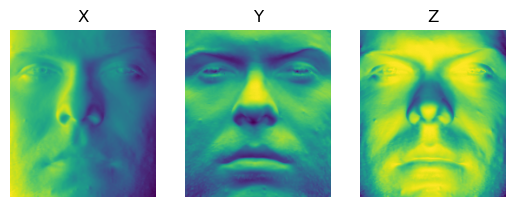

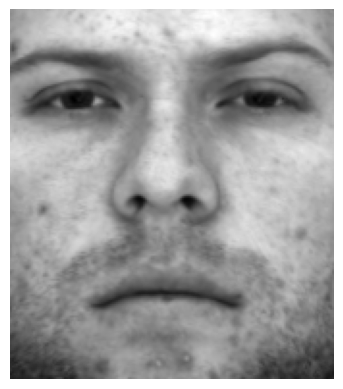

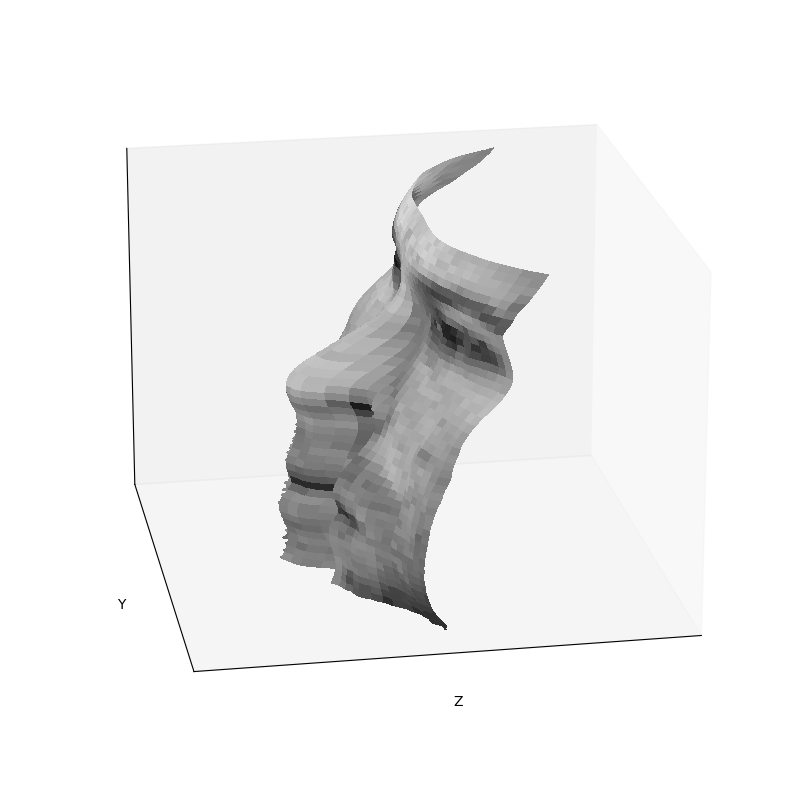

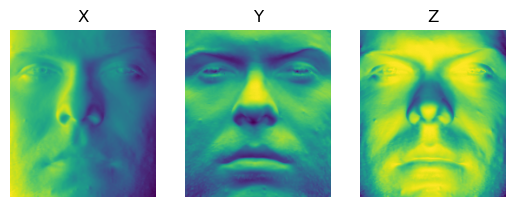

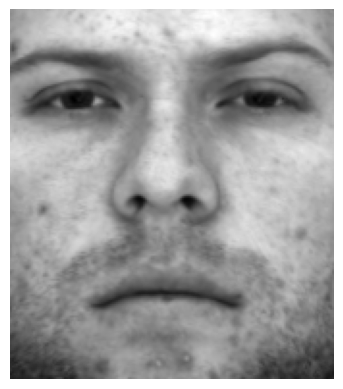

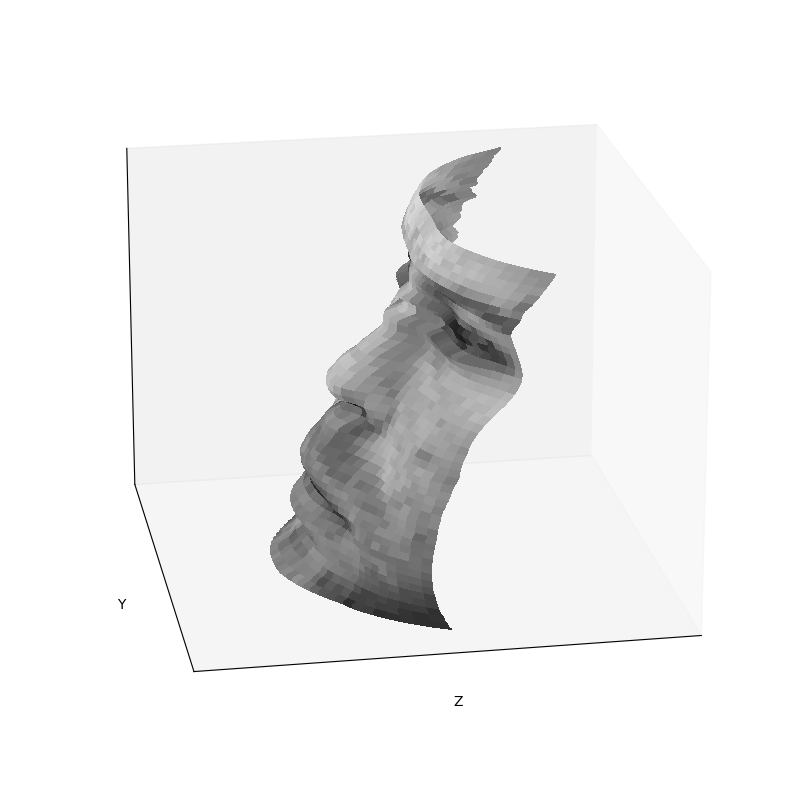

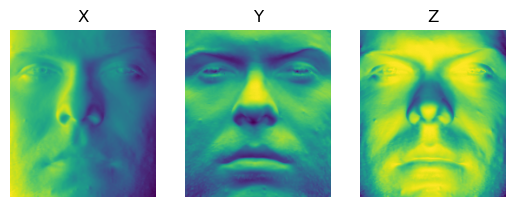

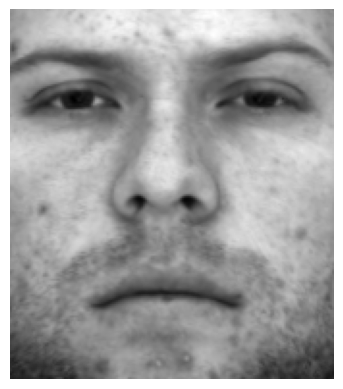

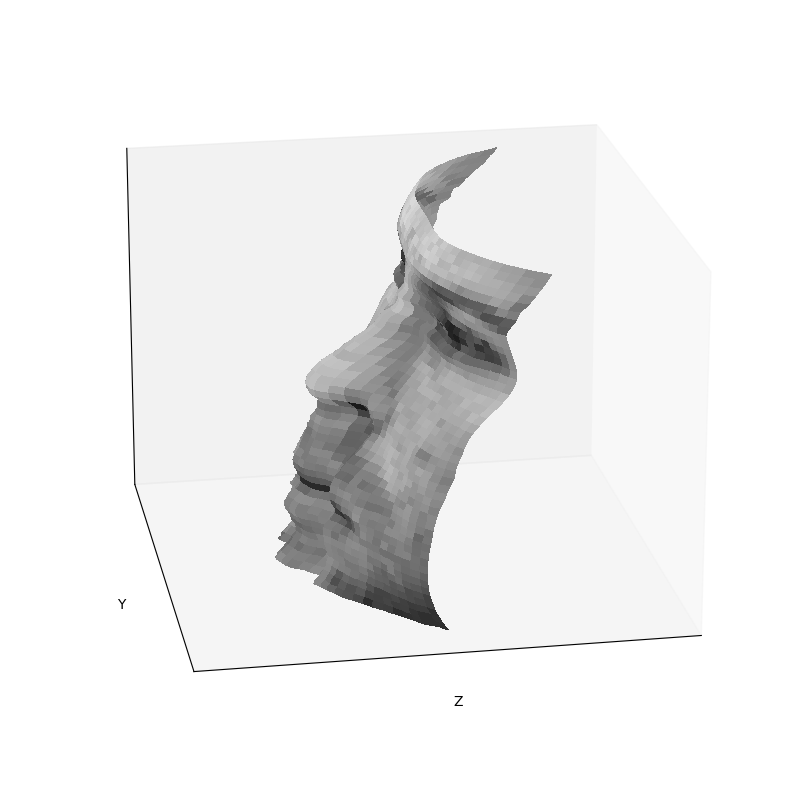

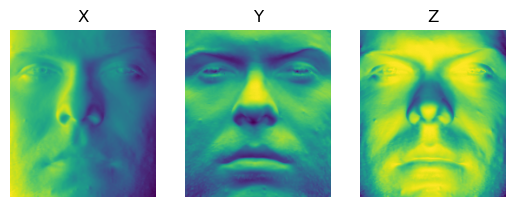

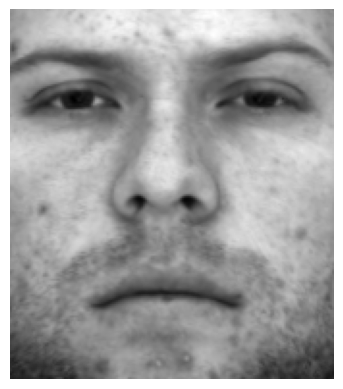

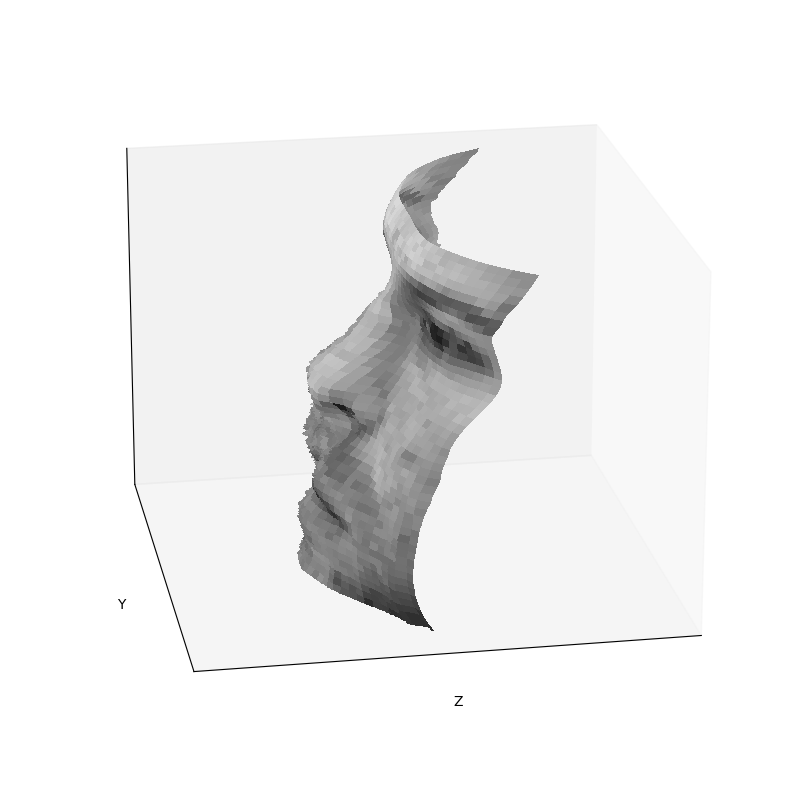

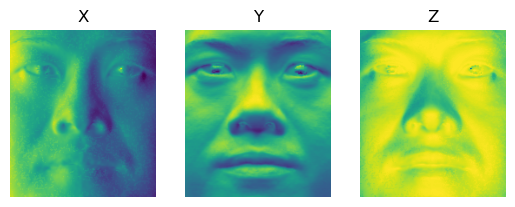

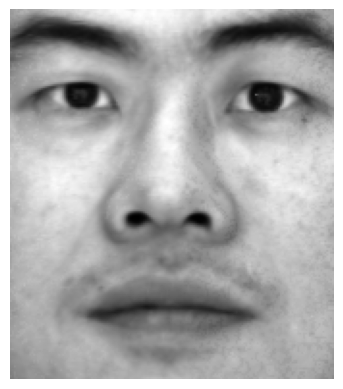

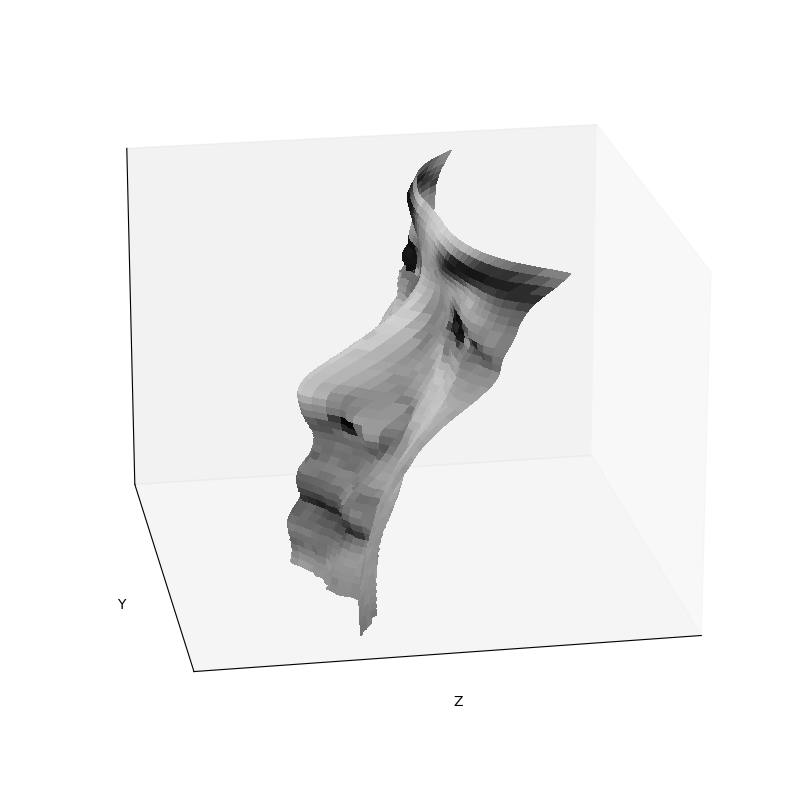

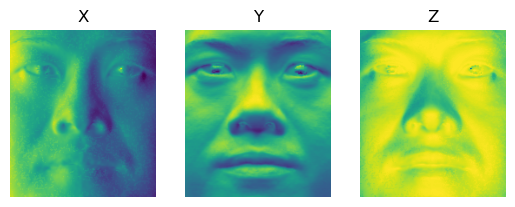

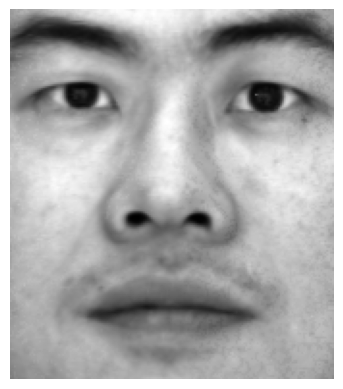

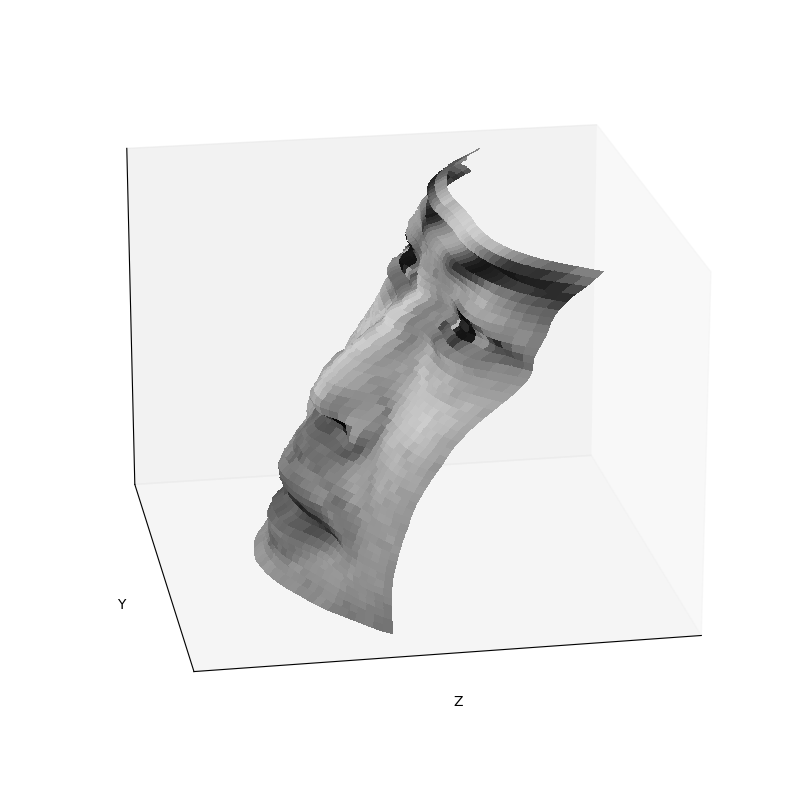

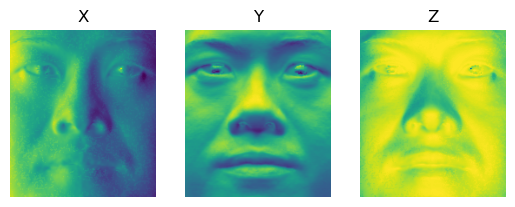

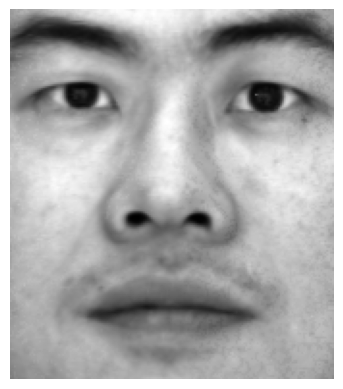

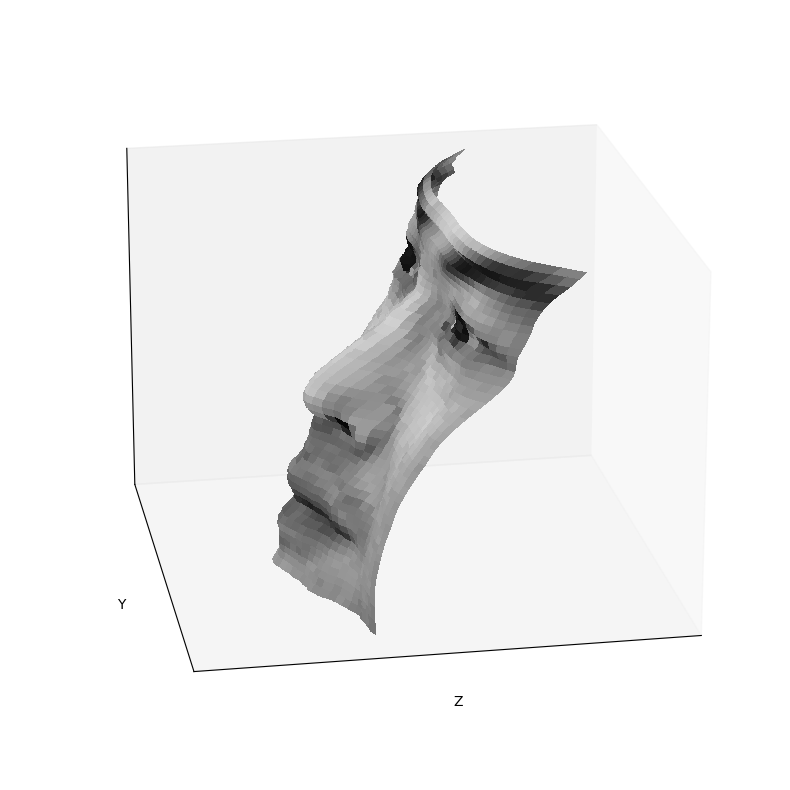

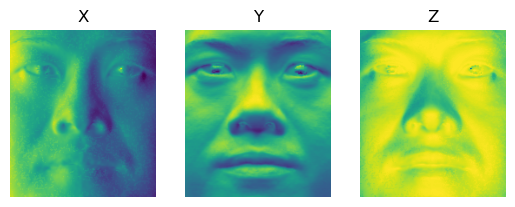

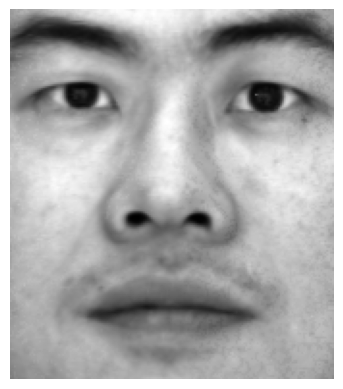

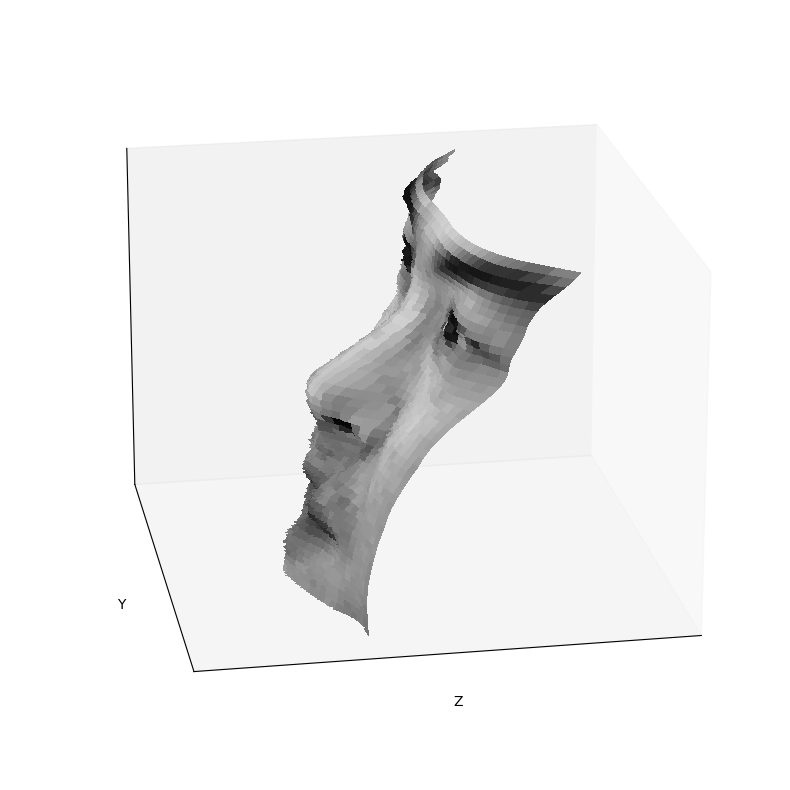

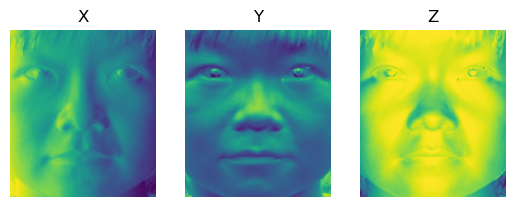

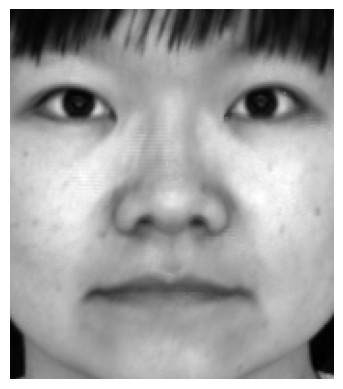

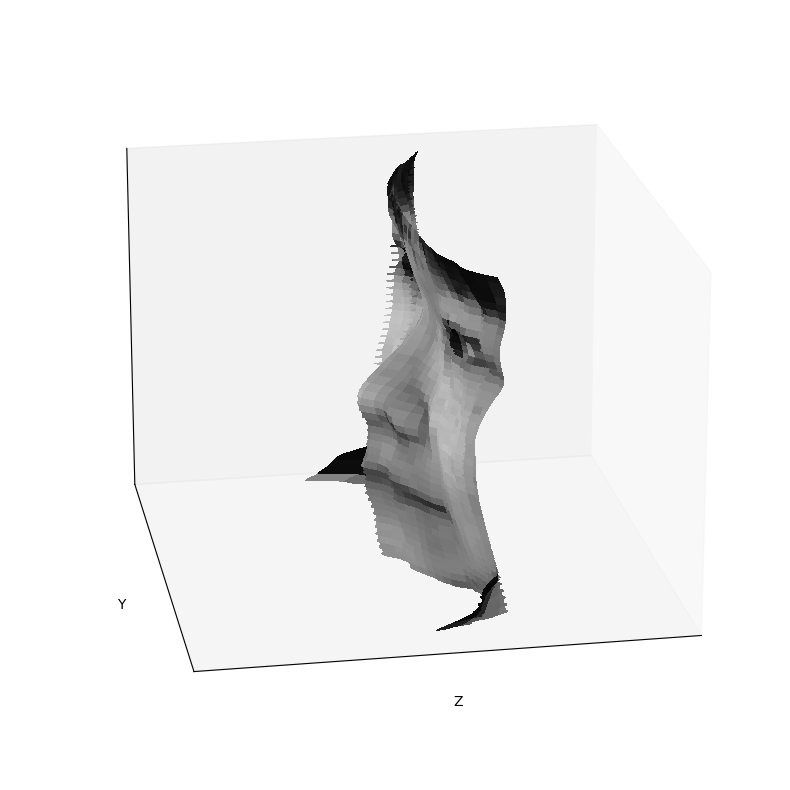

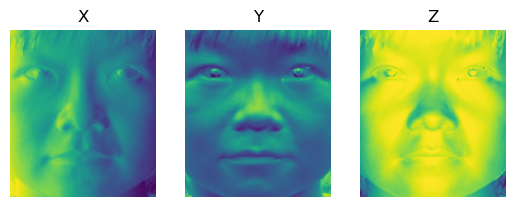

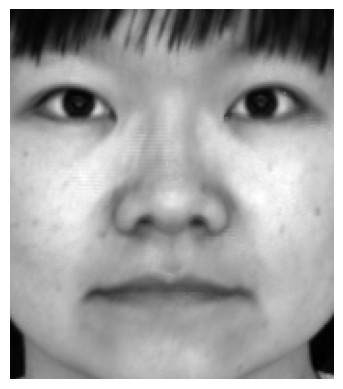

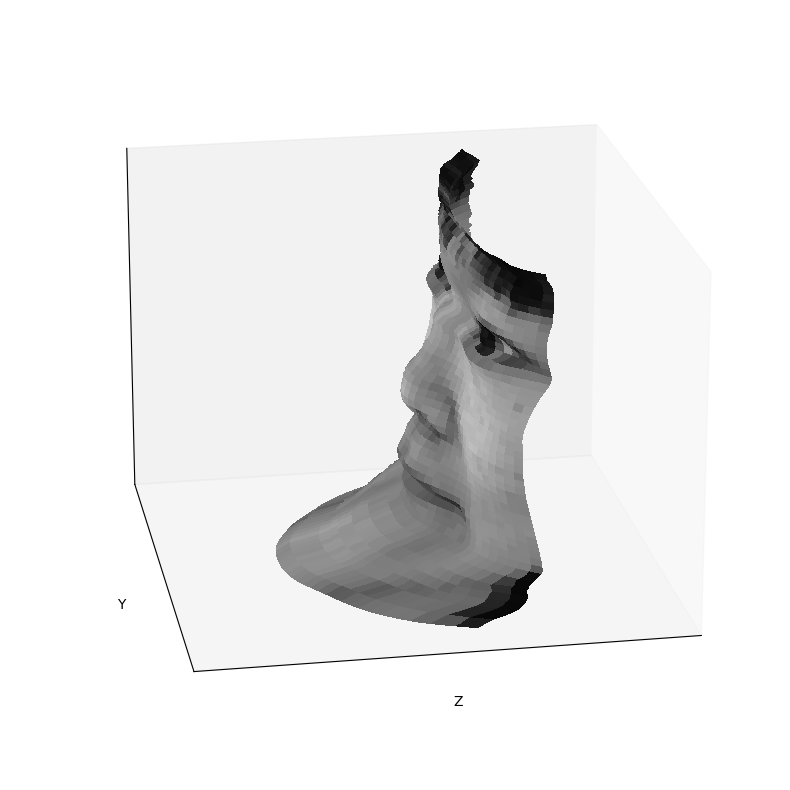

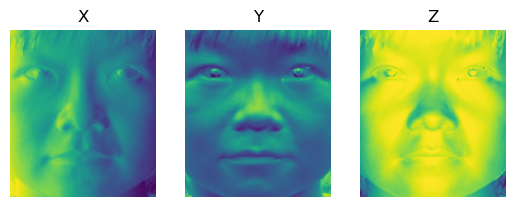

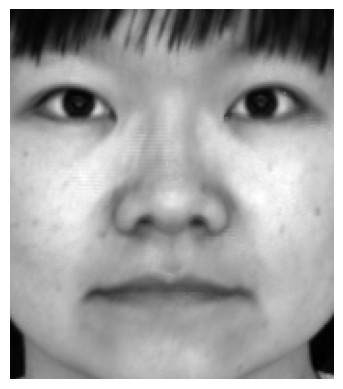

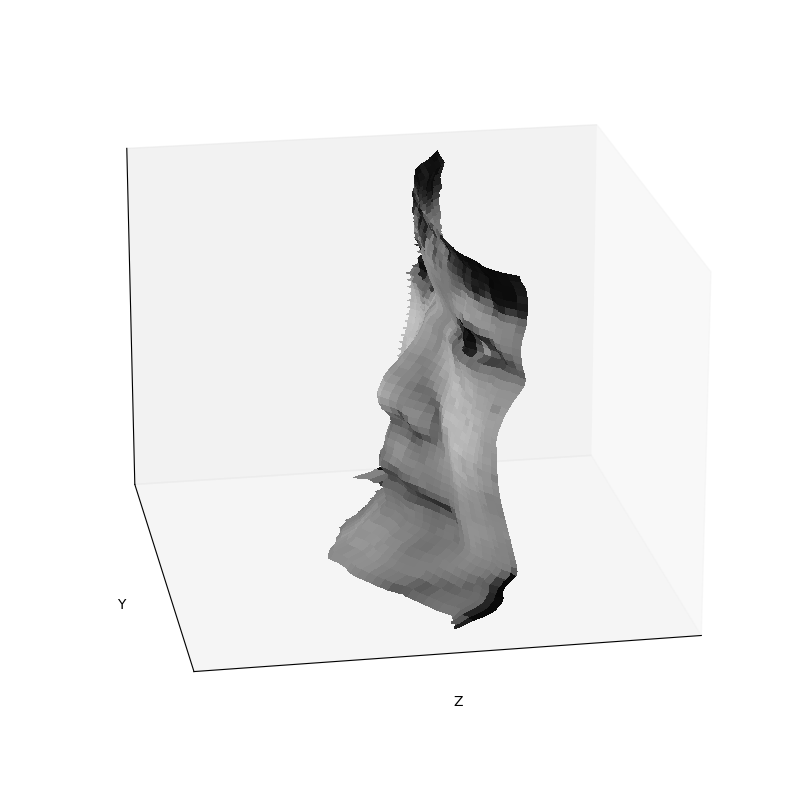

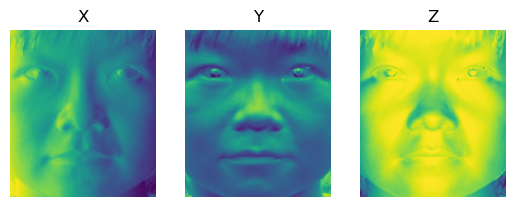

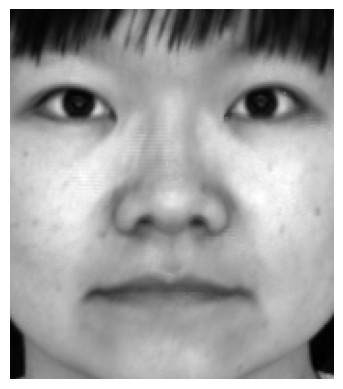

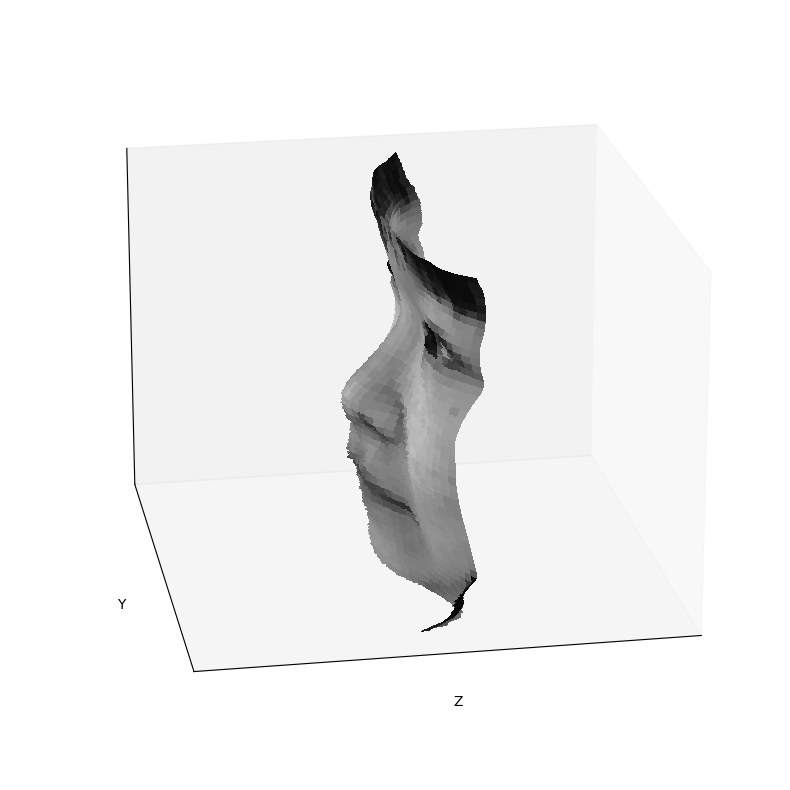

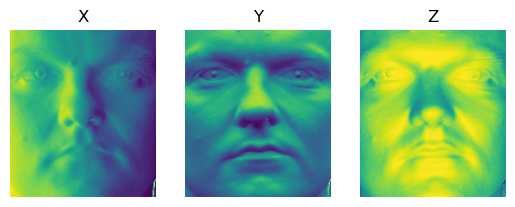

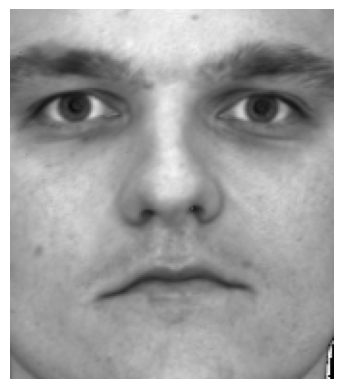

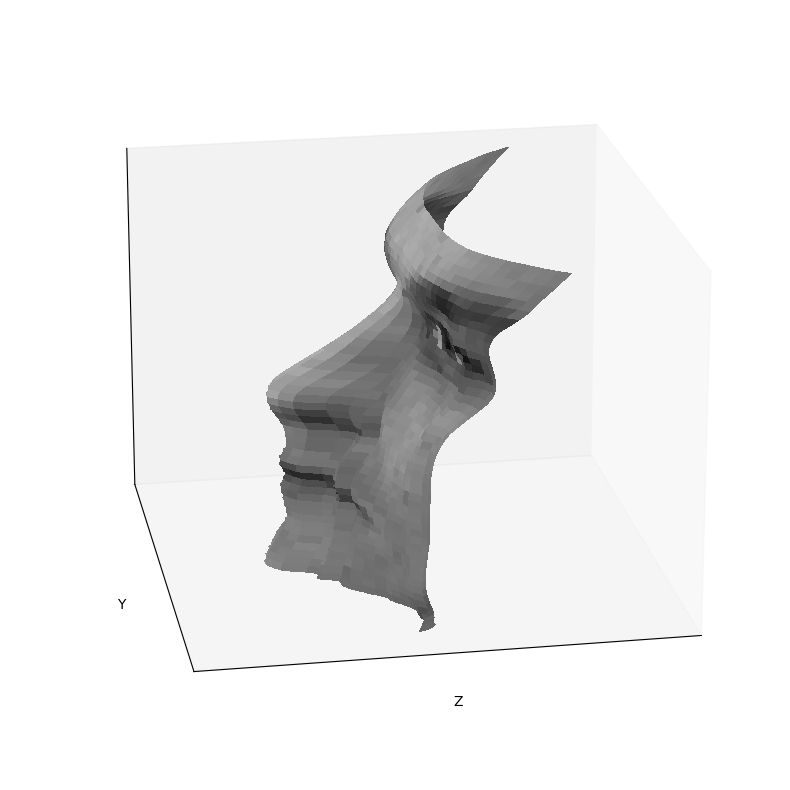

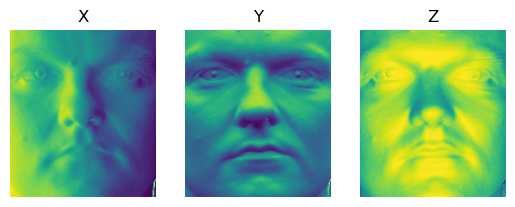

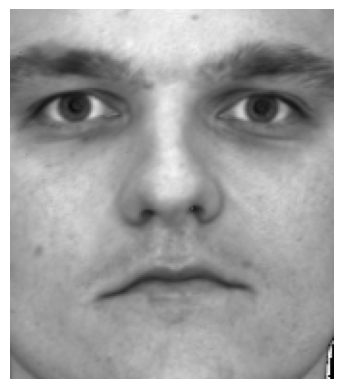

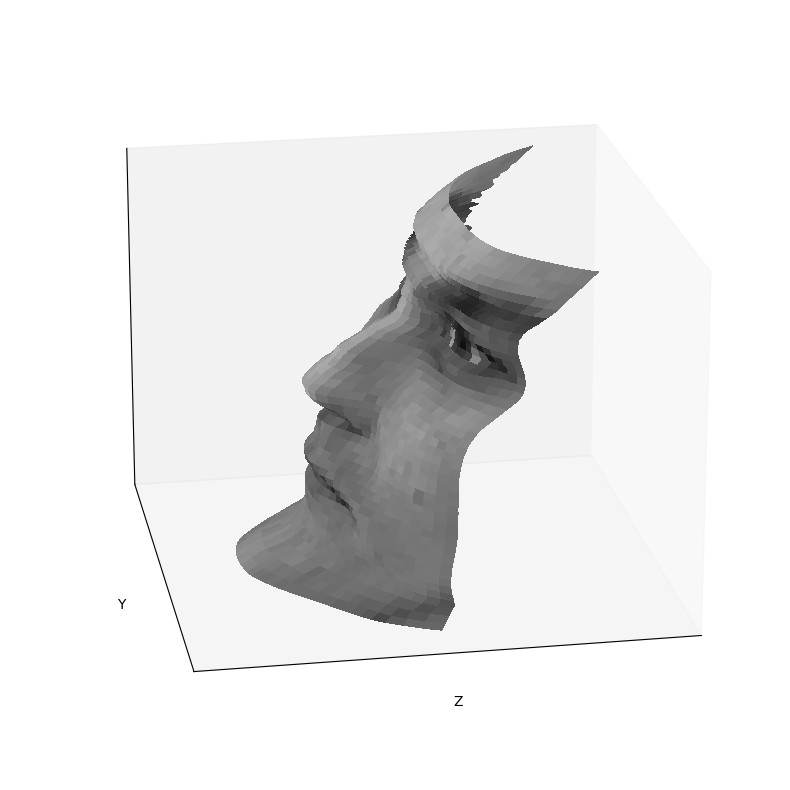

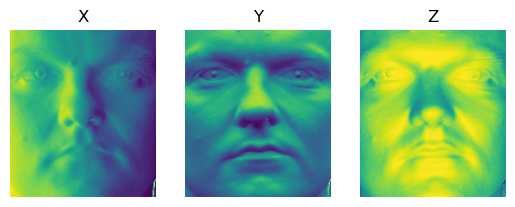

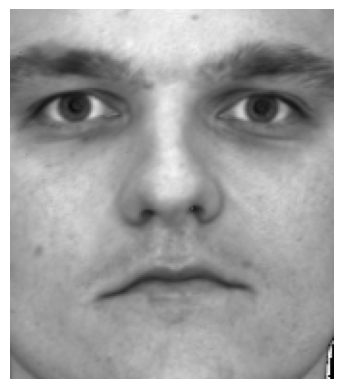

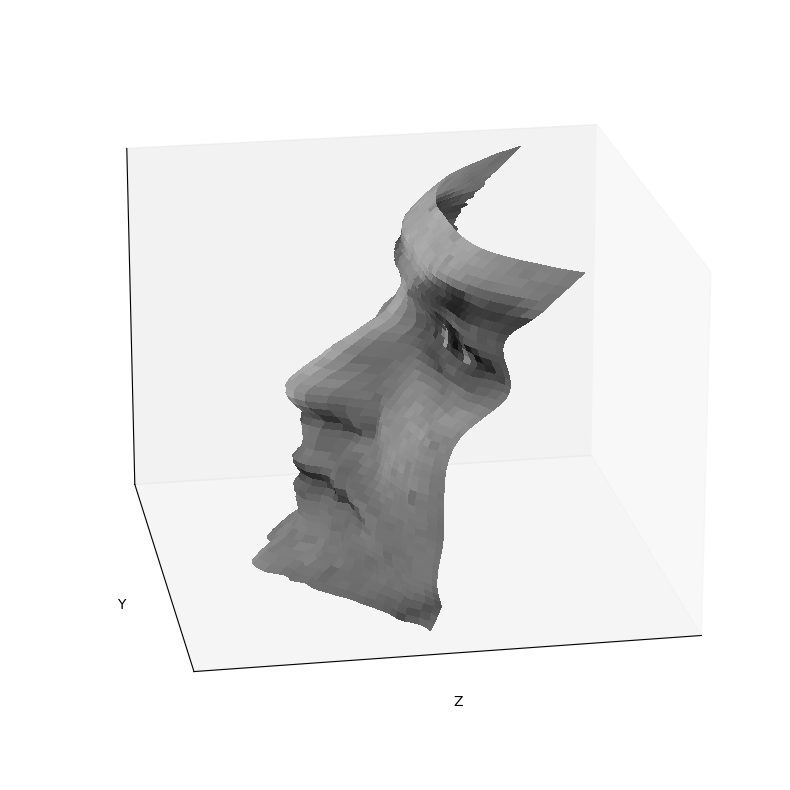

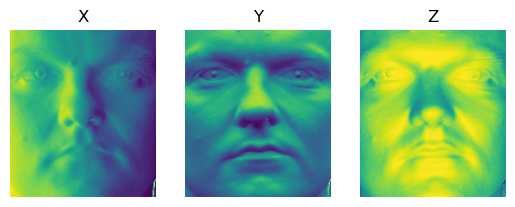

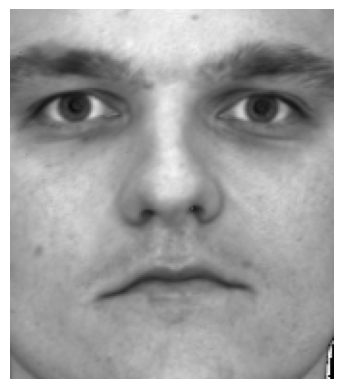

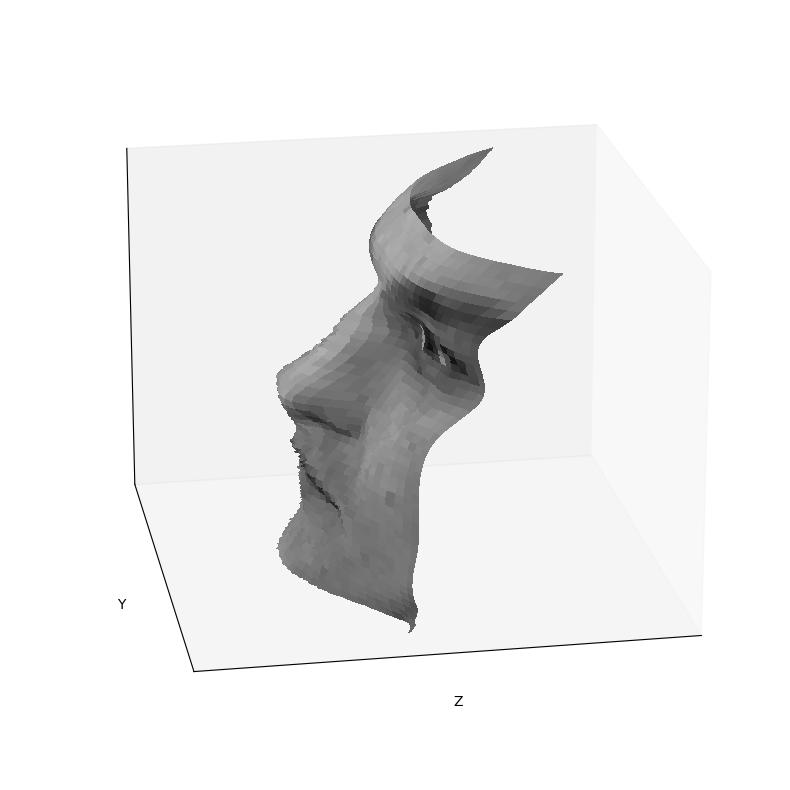

In [4]:
root_path = os.path.join(os.getcwd(), 'croppedyale')

for name in subject_names:
    full_path = os.path.join(root_path, name)
    ambient_image, imarray, light_dirs = LoadFaceImages(full_path, name,
                                                        64)

    processed_imarray = preprocess(ambient_image, imarray)

    albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                    light_dirs)    
    
    for method in ['column', 'row', 'average', 'random']:
        
        # timing
        start_time = time.time()

        # get surface
        height_map = get_surface(surface_normals, method)

        # timing
        end_time = time.time()
        total_time = end_time - start_time
        print("Surface Reconstruction Time for method: " + method + " - " + str(total_time))

        if save_flag and method == 'random':
            save_outputs(name, albedo_image, surface_normals)

        plot_surface_normals(surface_normals)

        display_output(albedo_image, height_map)